In [ ]:
%%capture
! pip install grad-cam timm

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
print('1')
img1 = cv2.resize(cv2.imread('/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/436219-7159-48057-[1, 0, 0].png'), (224, 224))
print('2')
img2 = cv2.imread('/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/std_shape/data_border_reflect_101/1.training/436219-7159-48057-[1, 0, 0].png')
print('3')
img3 = cv2.imread('/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/std_shape/data_border_constant/1.training/436219-7159-48057-[1, 0, 0].png')

1
2
3


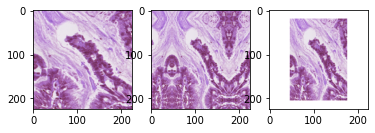

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
plt.imshow(img1)

ax = fig.add_subplot(1, 3, 2)
plt.imshow(img2)

ax = fig.add_subplot(1, 3, 3)
plt.imshow(img3)

In [ ]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [ ]:
img1_1 = preprocess_image(img1).to(device)
img2_1 = preprocess_image(img2).to(device)
img3_1 = preprocess_image(img3).to(device)

In [ ]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [ ]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_vit_base_patch16_224.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/model_vit_base_patch16_224_1.pth',
                                                      map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
model_vit_base_patch16_224.eval()

In [ ]:
target_layer = [model_vit_base_patch16_224.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

# 01. GradCAM

In [ ]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [ ]:
grayscale_cam1 = cam(input_tensor=img1_1, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=img2_1, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam3 = cam(input_tensor=img3_1, targets=[ClassifierOutputTarget(np.array([0]))])

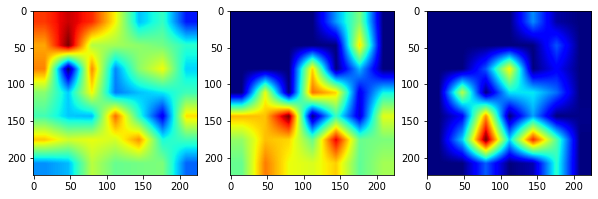

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

In [ ]:
show_cam_on_image(img1/255, grayscale_cam1[0, :])

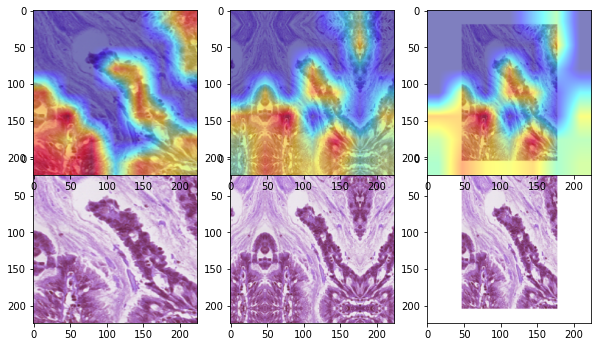

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(img1)

ax = fig.add_subplot(1, 3, 2)
plt.imshow(img2)

ax = fig.add_subplot(1, 3, 3)
plt.imshow(img3)

ax = fig.add_subplot(2, 3, 1)
plt.imshow(show_cam_on_image(img1/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 2)
plt.imshow(show_cam_on_image(img2/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 3)
plt.imshow(show_cam_on_image(img3/255, grayscale_cam2[0, :], use_rgb=True))

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

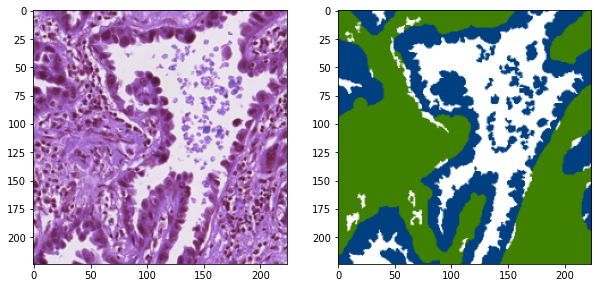

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

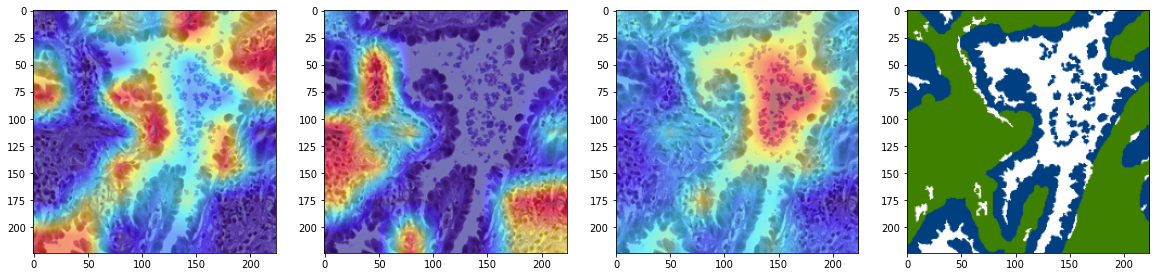

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
t_ls_0

[LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
t_ls

[[LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)]]

In [ ]:
type(t_ls[0])

list

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

In [ ]:
test_cam_mean.shape
test_cam_sum.shape

(1, 224, 224)

In [ ]:
test_cam_max.shape

(224, 224)

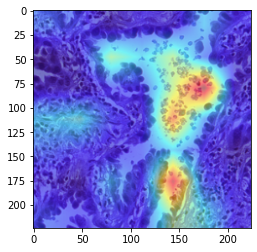

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))

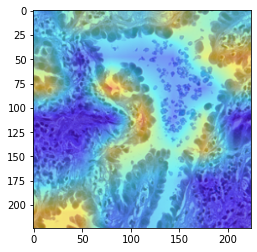

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))

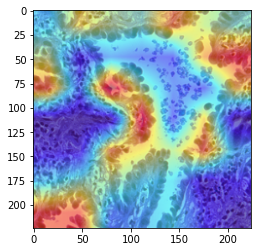

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True))

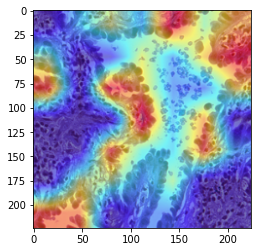

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

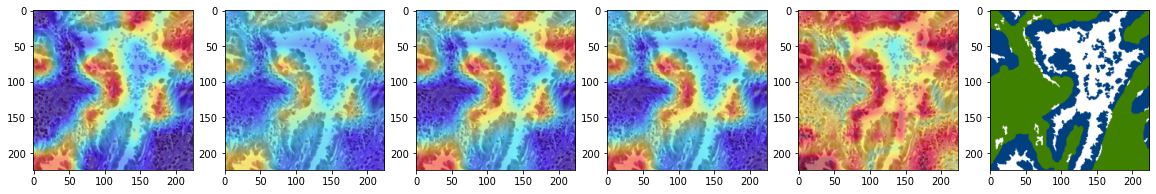

In [ ]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))     # from just the last block

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
test_cam_min = np.vstack(test_cams).min(axis=0)
test_cam_min.shape

(224, 224)

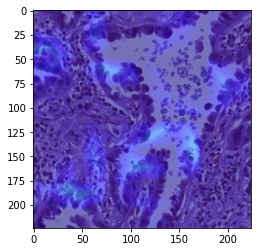

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, test_cam_min, use_rgb=True))

# 02. ScoreCAM

In [ ]:
cam = ScoreCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
               reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

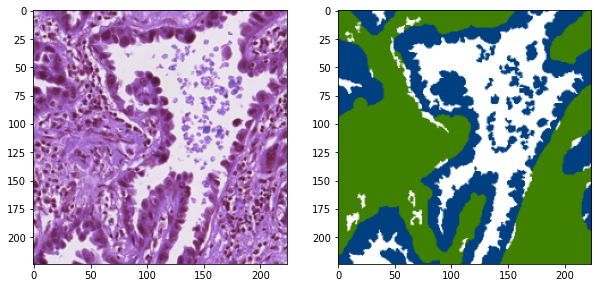

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

100%|██████████| 48/48 [01:49<00:00,  2.28s/it]


In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


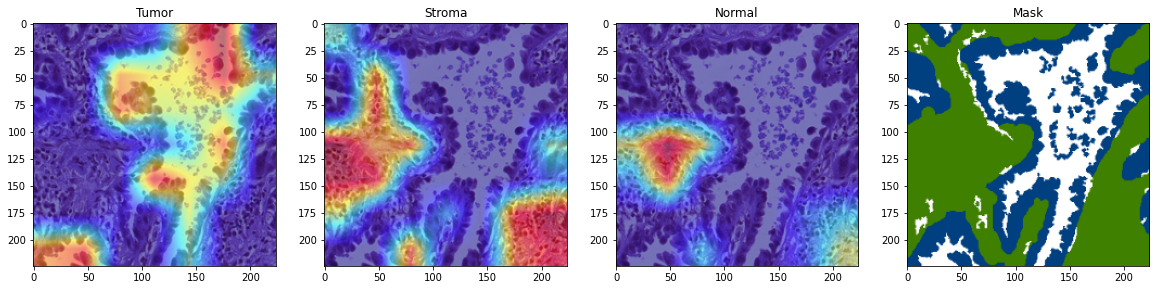

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 03. GradCAM++

In [ ]:
cam = GradCAMPlusPlus(model = model_vit_base_patch16_224, target_layers=target_layer,
                      reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

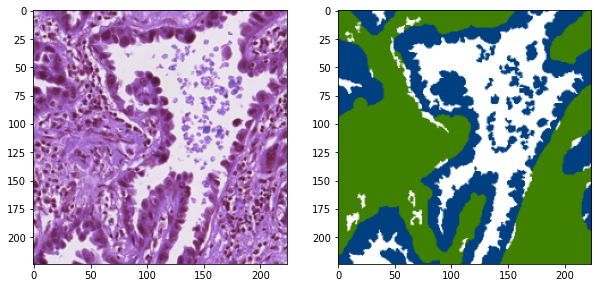

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


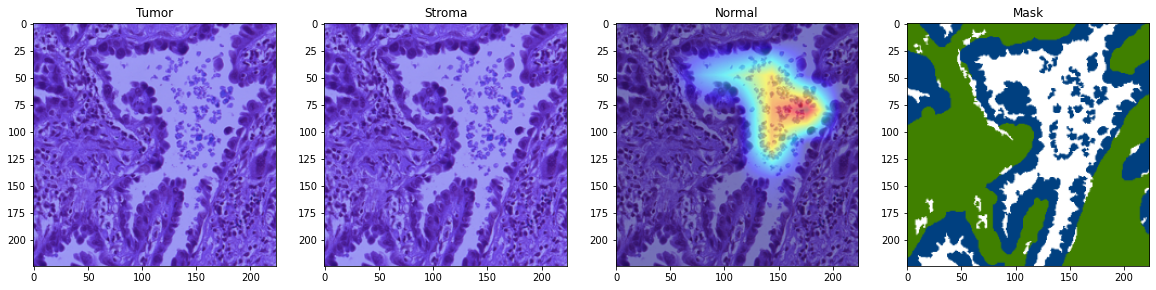

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 04. AblationCAM

In [ ]:
from pytorch_grad_cam.ablation_layer import AblationLayerVit

In [ ]:
cam = AblationCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
                  reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

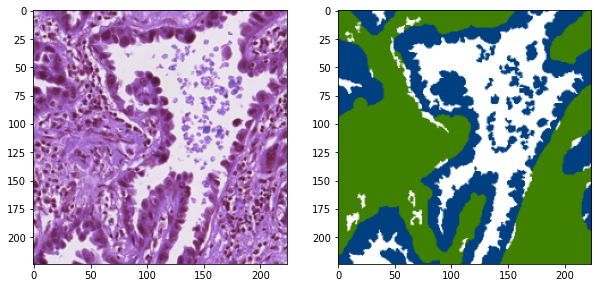

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


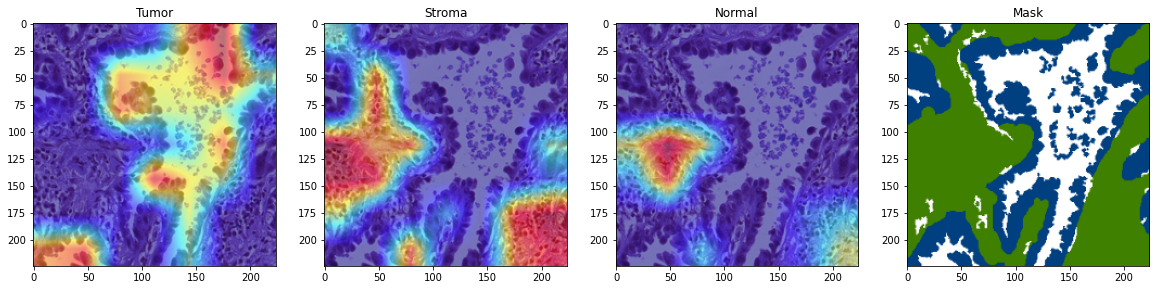

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 05. XGradCAM++

In [ ]:
cam = XGradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
               reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

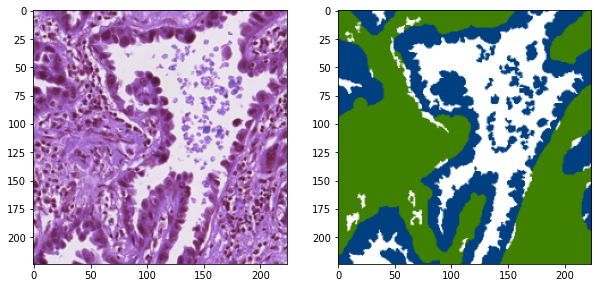

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


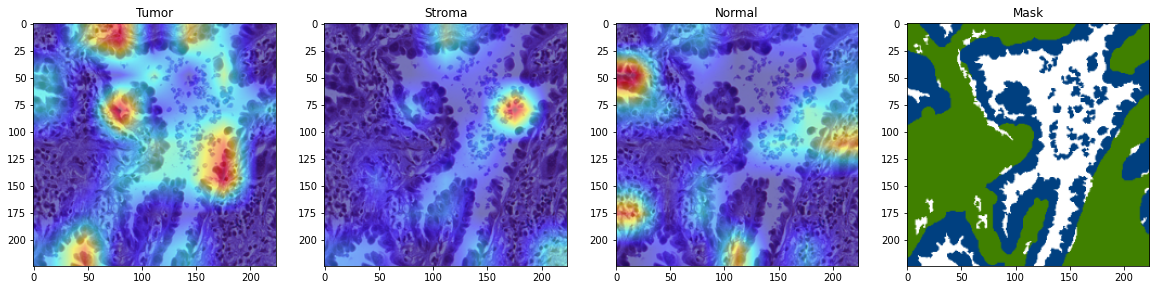

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 06. EigenCAM

In [ ]:
cam =EigenCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

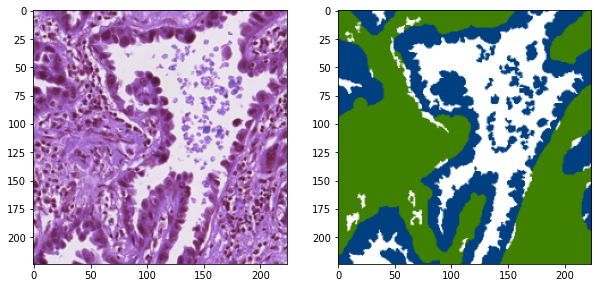

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


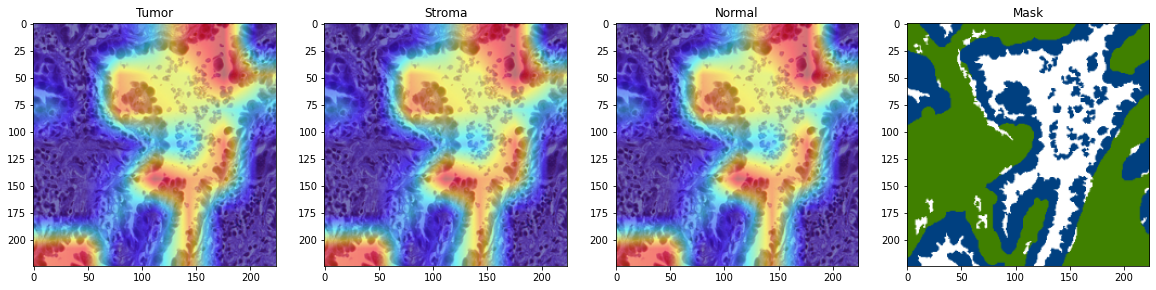

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 07. EigenGradCAM

In [ ]:
cam = EigenGradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
                      reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

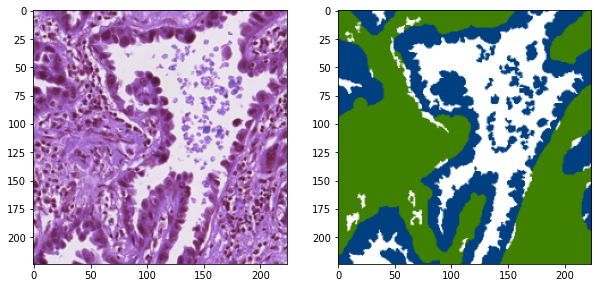

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


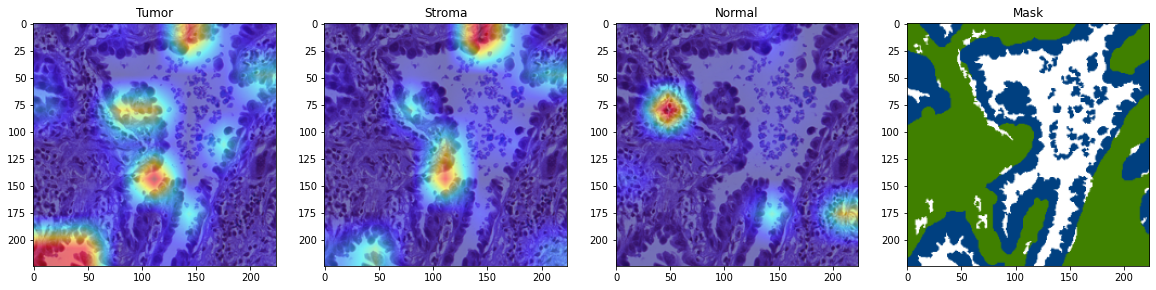

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 08. LayerCAM

In [ ]:
cam = LayerCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
                      reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

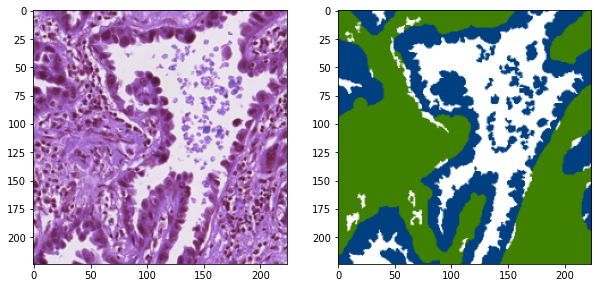

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


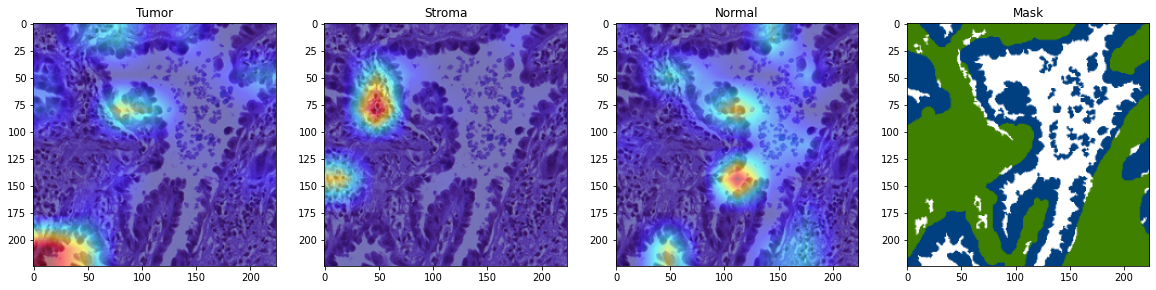

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# 09. FullGrad

In [ ]:
cam = FullGrad(model = model_vit_base_patch16_224, target_layers=target_layer,
                      reshape_transform=reshape_transform)

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

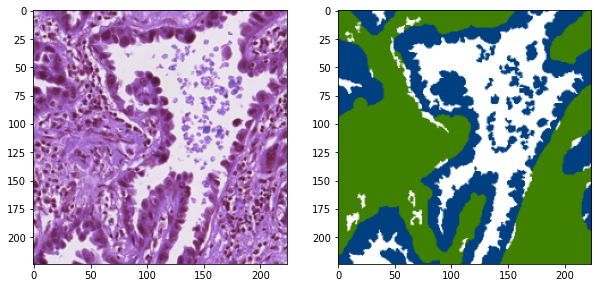

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
print(valid_cam_0.shape)
print(valid_cam_1.shape)
print(valid_cam_2.shape)

(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


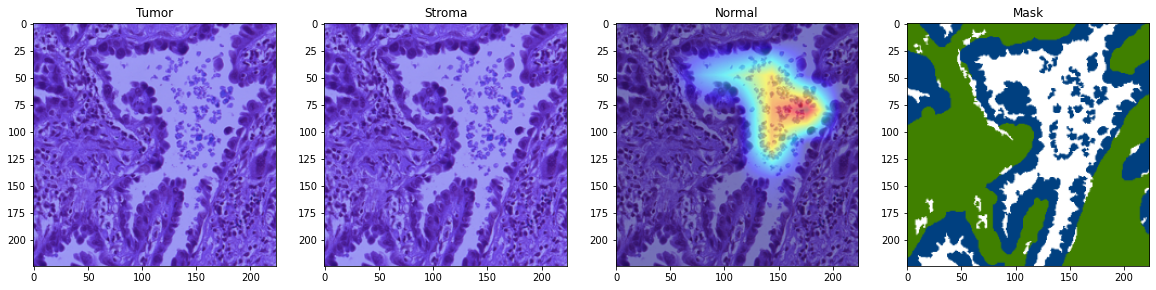

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
ax.title.set_text('Tumor')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
ax.title.set_text('Stroma')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
ax.title.set_text('Normal')
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
ax.title.set_text('Mask')
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# Explainability for Vision Transformers (JacobGil)

In [ ]:
!rm -r vit_explain

In [ ]:
!git clone https://github.com/jacobgil/vit-explain vit_explain

Cloning into 'vit_explain'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 96 (delta 36), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
from vit_explain.vit_rollout import VITAttentionRollout
from vit_explain.vit_grad_rollout import VITAttentionGradRollout

In [ ]:
valid_img = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_maks = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_maks), (224, 224))

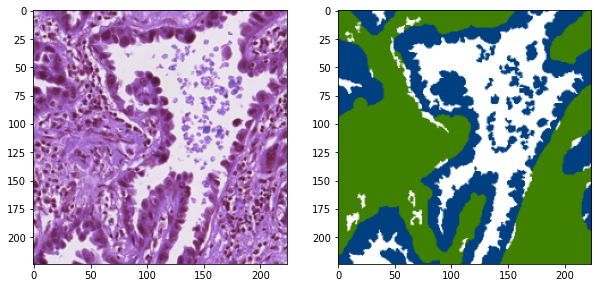

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_1 = preprocess_image(valid_img).to(device)

## Vanilla Attention rollout

In [ ]:
attention_rollout = VITAttentionRollout(model_vit_base_patch16_224, head_fusion='max',
                                        discard_ratio=0.5)

In [ ]:
cam = attention_rollout(valid_img_1)
cam.shape

In [ ]:
grad_rollout = VITAttentionGradRollout(model_vit_base_patch16_224, discard_ratio=0.9)

In [ ]:
cam = attention_rollout(valid_img_1)
cam.shape

RuntimeError: ignored

# EscVM

Trying to viz attention in the images via work from https://github.com/EscVM/EscVM_YT. shows individual patches which contribute the best. Better to use and continue woring on the above implementations

In [ ]:
!git clone https://github.com/EscVM/EscVM_YT

Cloning into 'EscVM_YT'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 96.58 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
from vision_transformers import VisionTransformer as ViT
from preprocess import visualize_attention

In [ ]:
test_model = ViT(img_size=(224, 224), patch_size=32, num_classes=3,
                 drop_rate=0.2, attn_drop_rate=0.2, qkv_bias=True).to(device)

In [ ]:
test_model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/model_vit_base_patch16_224_1.pth',
                                      map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png')

In [ ]:
img.shape

(273, 266, 3)

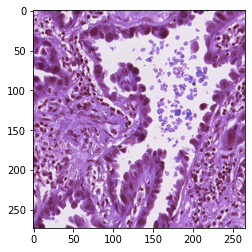

In [ ]:
plt.imshow(img)

In [ ]:
img_01 = preprocess_image(img)

In [ ]:
img_01.shape

torch.Size([1, 3, 224, 224])

In [ ]:
type(img_01) == torch.Tensor

True

In [ ]:
b, nc, h, w = img_01.shape

In [ ]:
b, nc, w, h

(1, 3, 224, 224)

In [ ]:
test_model.get_last_selfattention(img_01.to(device)).shape

torch.Size([1, 12, 50, 50])

In [ ]:
def visualize_attentions(model, img, patch_size, device):
  # make the image divisible by the patch size
  w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
  #img = img[:, :w, :h].unsqueeze(0)
  
  h_featmap = img.shape[-2] // patch_size
  w_featmap = img.shape[-1] // patch_size
  
  attentions = model.get_last_selfattention(img.to(device))
  
  nh = attentions.shape[1] # number of head
  
  # keep only the output patch attention
  attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
  
  attentions = attentions.reshape(nh, w_featmap, h_featmap)
  attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()
  
  return attentions

In [ ]:
def plot_attentions(img, attention):
  n_heads = attention.shape[0]
  plt.figure(figsize=(10,10))
  text = ["Original Image", "Head Mean"]
  for i, fig in enumerate([img, np.mean(attention, 0)]):
    plt.subplot(1, 2, i+1)
    print(i)
    if type(fig) == torch.Tensor:
      fig = fig.squeeze().detach().numpy()
    else:
      fig = fig.squeeze()
    #print(fig.shape)
    if len(fig.shape) > 2:
      plt.imshow(np.moveaxis(fig, 0, 2), cmap='jet')
    else:
      plt.imshow(fig, cmap='jet')
    plt.title(text[i])
  plt.show()
  
  plt.figure(figsize=(10,10))    
  for i in range(n_heads):
    plt.subplot(n_heads//3,3, i+1)
    plt.imshow(attention[i], cmap='jet')
    plt.title(f"Head n: {i+1}")
  plt.tight_layout()
  plt.show()

In [ ]:
#visualize_predict(test_model, valid_img_1, (224, 224), 32, device)

attention = visualize_attentions(test_model, img_01, 32, device)

In [ ]:
attention.shape

(12, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1


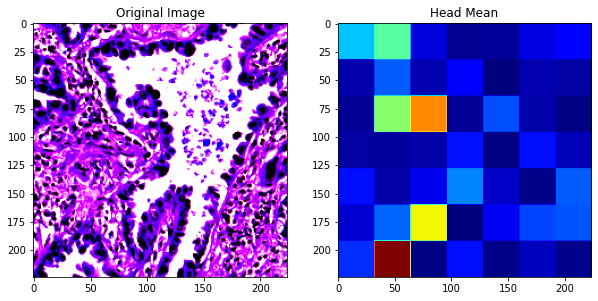

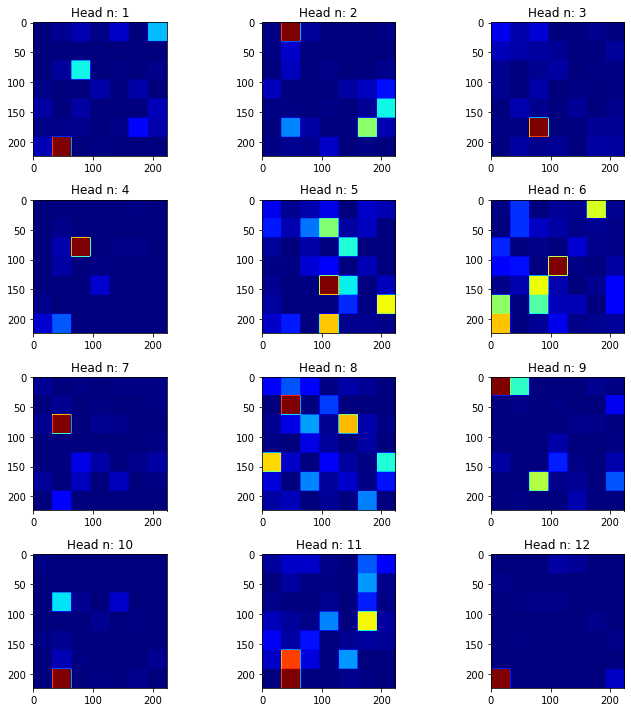

In [ ]:
plot_attentions(img_01, attention)